In [1]:
import numpyro
#numpyro.set_platform("cpu")
import jax
import jax.numpy as jnp
import jax.random as jr 
import numpyro.distributions as dist

from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, List, Callable
import sys
sys.path.append("../")

In [2]:
data = jnp.load('oscilator1_data.npy', allow_pickle=True).item()
X, Y, Y_f = data['X'], data['Y'], data['Y_f']

/home/tobias/miniconda3/envs/numpyro_env/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


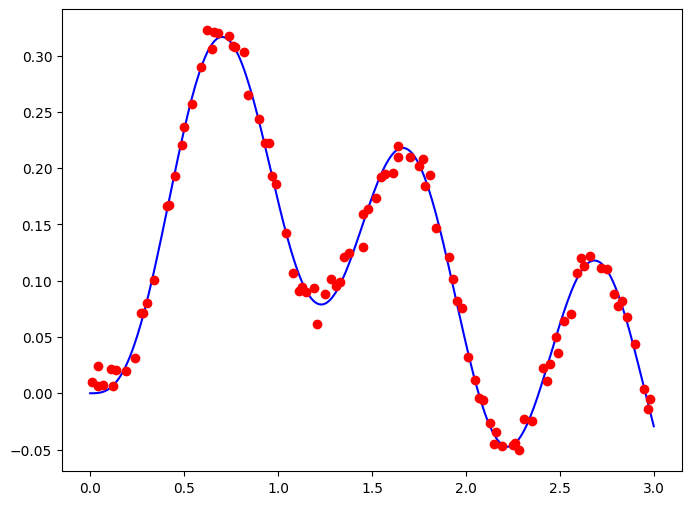

In [3]:
from scipy.stats.qmc import Sobol

def sample_training_points_space_filling(
        X, 
        Y_1, 
        Y_2, 
        num_samples, 
        seed=0
):
    """
    Sample training points from X, Y_1, and Y_2 using Sobol sequences.
    Generates different X positions for Y_1 and Y_2.
    """
    num_total_samples = X.shape[0]
    
    # Initialize Sobol sequence samplers for Y_1 and Y_2
    sobol_1 = Sobol(d=1, scramble=True, seed=seed)
    sobol_2 = Sobol(d=1, scramble=True, seed=seed + 1)  # Different seed for different sequence
    
    sobol_samples_1 = sobol_1.random(num_samples)
    sobol_samples_2 = sobol_2.random(num_samples)
    
    indices_1 = (sobol_samples_1 * num_total_samples).astype(int).flatten()
    indices_2 = (sobol_samples_2 * num_total_samples).astype(int).flatten()
    
    indices_1 = jnp.clip(indices_1, 0, num_total_samples - 1)
    indices_2 = jnp.clip(indices_2, 0, num_total_samples - 1)
    
    # Sample from the arrays using the Sobol sequence indices
    X_samples_1 = X[indices_1] 
    Y_1_samples = Y_1[indices_1] + jr.normal(jr.PRNGKey(seed), shape=(num_samples, )) * 1e-2
    X_samples_2 = X[indices_2]
    Y_2_samples = Y_2[indices_2]+ jr.normal(jr.PRNGKey(seed), shape=(num_samples, )) * 1e-2
    
    # test set without the training points



    return X_samples_1[:,None], Y_1_samples[:,None], X_samples_2[:,None], Y_2_samples[:,None], X[:,None], Y_1[:,None], Y_2[:,None]

# Sample training points
X_train, Y_train,X_f_samples, Y_f_samples, X_test, Y_1_test, Y_2_test = sample_training_points_space_filling(X, Y, Y_f, 100, seed=0)

# Plot the sampled training points
plt.figure(figsize=(8, 6))
plt.plot(X, Y, 'b', label='Y')
plt.plot(X_train, Y_train, 'ro', label='Y samples')
#plt.plot(X, Y_f, 'g', label='Y_f')
#plt.plot(X_f_samples, Y_f_samples, 'go', label='Y_f samples')
#plt.legend()



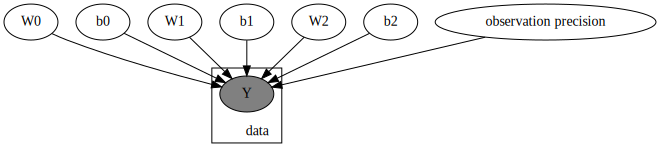

In [4]:
def dense_layer(
        i: int,
        size: List[int],
):  
    #Xavier initialization
    alpha_sq = 2/(size[0] + size[1])
    alpha_sq = 1.0
    W = numpyro.sample(f"W{i}", dist.Normal(0, alpha_sq**0.5).expand(size))
    b = numpyro.sample(f"b{i}", dist.Normal(0, alpha_sq**0.5).expand((size[-1],)))
    return W, b

def forward(
        W: List[jax.Array],
        b: List[jax.Array],
        X: jax.Array,
        activation: Callable,
):
    #input layer
    z = activation(jnp.dot(X, W[0]) + b[0])

    #hidden layers
    for i in range(1, len(W) - 1):
        z = activation(jnp.dot(z, W[i]) + b[i])

    #output layer with no activation
    z = jnp.dot(z, W[-1]) + b[-1]
    return z

def wideband_dnn(
        X: jax.Array,
        Y: jax.Array,
        layers: List[int],
):
    N, input_dim = X.shape
    activation = jnp.tanh
    W = []
    b = []
    #build the layers with the given list
    for i, layer in enumerate(layers):
        W_, b_ = dense_layer(i, [input_dim, layer])
        W.append(W_)
        b.append(b_)
        input_dim = layer
    #forward pass through the network
    z = forward(W, b, X, activation)
    if Y is not None:
        assert Y.shape == z.shape , f"Y shape {Y.shape} does not match z shape {z.shape}"

    precision_obs = numpyro.sample(r"observation precision", dist.Gamma(2., 1.))
    sigma_obs = 1.0 / jnp.sqrt(precision_obs)

    with numpyro.plate("data", N):
        numpyro.sample(
            "Y", 
            dist.Normal(z, sigma_obs).to_event(1), 
            obs=Y
        )


LAYERS = [100, 100, 1]

try:
    render = numpyro.render_model(wideband_dnn, (X_train, Y_train, LAYERS))
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")
render

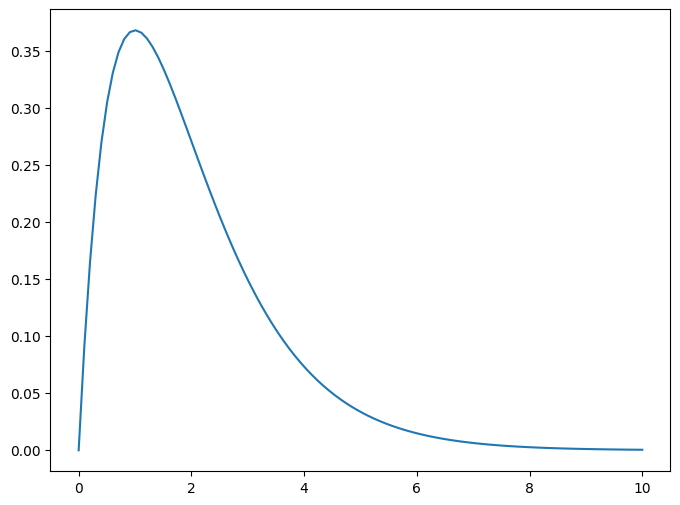

In [136]:
#plot gamma distribution
x = jnp.linspace(0, 10, 100)
y = dist.Gamma(2., 1.).log_prob(x)
plt.figure(figsize=(8, 6))
plt.plot(x, jnp.exp(y))

In [138]:
from numpyro.infer import NUTS, MCMC

mcmc = MCMC(NUTS(wideband_dnn), num_warmup=1000, num_samples=1000)
mcmc.run(jax.random.PRNGKey(0), X_train, Y_train, LAYERS)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [04:36<00:00,  7.23it/s, 1023 steps of size 6.49e-04. acc. prob=0.93]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                W0[0,0]     -0.06      0.98      0.06     -1.71      1.31     12.27      1.10
                W0[0,1]     -0.14      0.82     -0.11     -1.71      1.05     33.64      1.10
                W0[0,2]     -0.03      0.84     -0.09     -1.29      1.37     25.33      1.21
                W0[0,3]     -0.04      0.92     -0.03     -1.66      1.33     15.52      1.10
                W0[0,4]     -0.24      0.72     -0.22     -1.44      0.90     27.59      1.06
                W0[0,5]      0.12      0.95      0.10     -1.46      1.72     40.72      1.06
                W0[0,6]      0.14      0.67      0.10     -0.96      1.27     61.09      1.00
                W0[0,7]      0.22      0.95      0.13     -1.22      1.88     25.26      1.01
                W0[0,8]     -0.17      0.89     -0.15     -1.70      1.17     29.00      1.03
                W0[0,9]     -0.05      0.79     -0.03     -

In [8]:
#inference with svi
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoLaplaceApproximation, AutoMultivariateNormal, AutoIAFNormal, AutoLowRankMultivariateNormal, AutoDelta

guide = AutoDelta(wideband_dnn)


svi = SVI(
    wideband_dnn, guide, numpyro.optim.Adam(0.05), Trace_ELBO()
)

svi_result = svi.run(
    jax.random.PRNGKey(0),
    num_steps=3000,
    X=X_train,
    Y=Y_train,
    layers=LAYERS
)

100%|██████████| 3000/3000 [00:02<00:00, 1188.06it/s, init loss: 10469.5088, avg. loss [2851-3000]: 9512.2354]


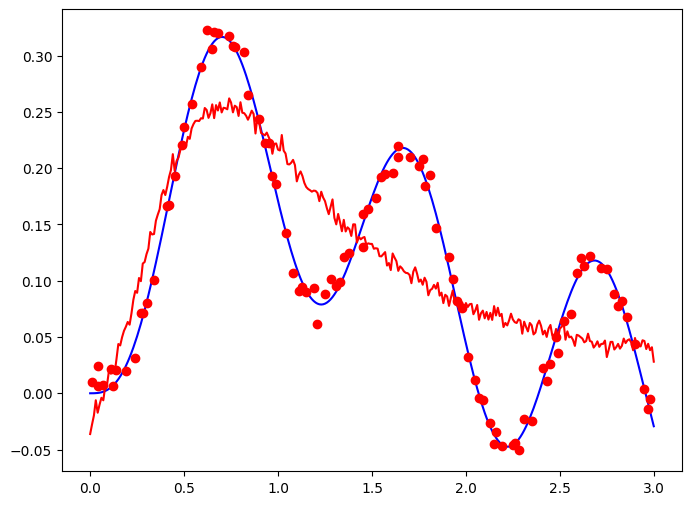

In [9]:
samples = guide.sample_posterior(jax.random.PRNGKey(1), svi_result.params, sample_shape=(1000,))
#predictive
predictive = Predictive(wideband_dnn, samples, return_sites=["Y"])
predictions = predictive(jax.random.PRNGKey(1), X_test, None, LAYERS)

# Plot the sampled training points
plt.figure(figsize=(8, 6))
plt.plot(X, Y, 'b', label='Y')
plt.plot(X_train, Y_train, 'ro', label='Y samples')

# Plot the predictions
mean_prediction = jnp.mean(predictions["Y"], axis=0)
stddev_prediction = jnp.std(predictions["Y"], axis=0)
plt.plot(X_test, mean_prediction, 'r', label='Predictive mean')
#plot gamma distribution



In [37]:
# Predictive distribution
predictive = Predictive(wideband_dnn, guide=guide, num_samples=1000, return_sites=["Y"])
samples = predictive(jax.random.PRNGKey(2), X=X_test[:,None], Y=None, layers=LAYERS)

In [38]:
mean = jnp.mean(samples["Y"], axis=0)
mean.shape

(301,)

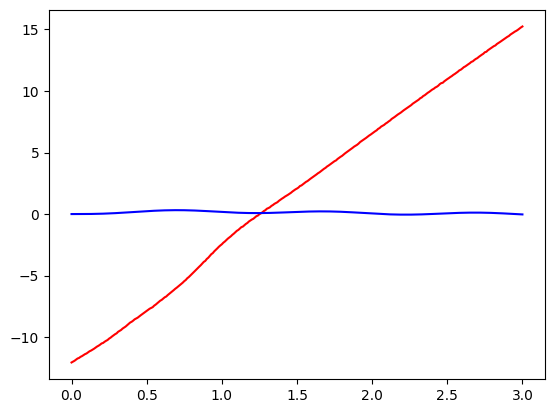

In [39]:
plt.plot(X_test, mean, 'r', label='Predictive mean')
plt.plot(X, Y, 'b', label='True Y')